<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 12
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


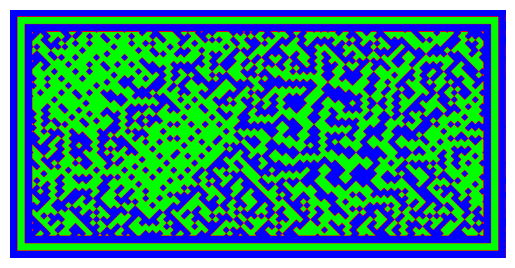

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [8]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [10]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [12]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
    nn.Softmax(dim=1)
)

  5%|▌         | 1/20 [00:15<05:00, 15.81s/it]

EPOCH: 01/20 LOSS: 1.0894 ACC: 0.3731  VAL-LOSS: 1.0377 VAL-ACC: 0.5055  TEST-LOSS: 1.0390 TEST-ACC: 0.4940 


 10%|█         | 2/20 [00:32<04:56, 16.46s/it]

EPOCH: 02/20 LOSS: 0.9881 ACC: 0.5385  VAL-LOSS: 0.8889 VAL-ACC: 0.6600  TEST-LOSS: 0.9095 TEST-ACC: 0.6280 


 15%|█▌        | 3/20 [00:48<04:36, 16.29s/it]

EPOCH: 03/20 LOSS: 0.8638 ACC: 0.6764  VAL-LOSS: 0.8088 VAL-ACC: 0.7265  TEST-LOSS: 0.8057 TEST-ACC: 0.7520 


 20%|██        | 4/20 [01:03<04:13, 15.83s/it]

EPOCH: 04/20 LOSS: 0.7977 ACC: 0.7471  VAL-LOSS: 0.7447 VAL-ACC: 0.8000  TEST-LOSS: 0.7544 TEST-ACC: 0.7840 


 25%|██▌       | 5/20 [01:20<04:01, 16.11s/it]

EPOCH: 05/20 LOSS: 0.7505 ACC: 0.7919  VAL-LOSS: 0.7061 VAL-ACC: 0.8480  TEST-LOSS: 0.7014 TEST-ACC: 0.8500 


 30%|███       | 6/20 [01:36<03:44, 16.07s/it]

EPOCH: 06/20 LOSS: 0.7121 ACC: 0.8333  VAL-LOSS: 0.6823 VAL-ACC: 0.8690  TEST-LOSS: 0.6847 TEST-ACC: 0.8620 


 35%|███▌      | 7/20 [01:53<03:32, 16.35s/it]

EPOCH: 07/20 LOSS: 0.6895 ACC: 0.8592  VAL-LOSS: 0.6607 VAL-ACC: 0.8910  TEST-LOSS: 0.6583 TEST-ACC: 0.8980 


 40%|████      | 8/20 [02:08<03:12, 16.06s/it]

EPOCH: 08/20 LOSS: 0.6679 ACC: 0.8797  VAL-LOSS: 0.6393 VAL-ACC: 0.9140  TEST-LOSS: 0.6512 TEST-ACC: 0.9000 


 45%|████▌     | 9/20 [02:24<02:53, 15.81s/it]

EPOCH: 09/20 LOSS: 0.6517 ACC: 0.8981  VAL-LOSS: 0.6338 VAL-ACC: 0.9175  TEST-LOSS: 0.6347 TEST-ACC: 0.9200 


 50%|█████     | 10/20 [02:39<02:36, 15.62s/it]

EPOCH: 10/20 LOSS: 0.6487 ACC: 0.9011  VAL-LOSS: 0.6274 VAL-ACC: 0.9235  TEST-LOSS: 0.6333 TEST-ACC: 0.9220 


 55%|█████▌    | 11/20 [02:54<02:19, 15.51s/it]

EPOCH: 11/20 LOSS: 0.6436 ACC: 0.9053  VAL-LOSS: 0.6214 VAL-ACC: 0.9310  TEST-LOSS: 0.6258 TEST-ACC: 0.9260 


 60%|██████    | 12/20 [03:09<02:02, 15.34s/it]

EPOCH: 12/20 LOSS: 0.6309 ACC: 0.9199  VAL-LOSS: 0.6125 VAL-ACC: 0.9400  TEST-LOSS: 0.6162 TEST-ACC: 0.9380 


 65%|██████▌   | 13/20 [03:24<01:46, 15.26s/it]

EPOCH: 13/20 LOSS: 0.6243 ACC: 0.9251  VAL-LOSS: 0.6021 VAL-ACC: 0.9460  TEST-LOSS: 0.6055 TEST-ACC: 0.9360 


 70%|███████   | 14/20 [03:39<01:31, 15.17s/it]

EPOCH: 14/20 LOSS: 0.6178 ACC: 0.9319  VAL-LOSS: 0.6023 VAL-ACC: 0.9465  TEST-LOSS: 0.6010 TEST-ACC: 0.9480 


 75%|███████▌  | 15/20 [03:54<01:15, 15.05s/it]

EPOCH: 15/20 LOSS: 0.6137 ACC: 0.9373  VAL-LOSS: 0.6012 VAL-ACC: 0.9485  TEST-LOSS: 0.6031 TEST-ACC: 0.9460 


 80%|████████  | 16/20 [04:09<01:00, 15.16s/it]

EPOCH: 16/20 LOSS: 0.6087 ACC: 0.9409  VAL-LOSS: 0.5938 VAL-ACC: 0.9585  TEST-LOSS: 0.6037 TEST-ACC: 0.9480 


 85%|████████▌ | 17/20 [04:25<00:45, 15.27s/it]

EPOCH: 17/20 LOSS: 0.6058 ACC: 0.9452  VAL-LOSS: 0.5956 VAL-ACC: 0.9555  TEST-LOSS: 0.6013 TEST-ACC: 0.9500 


 90%|█████████ | 18/20 [04:37<00:28, 14.44s/it]

EPOCH: 18/20 LOSS: 0.6071 ACC: 0.9417  VAL-LOSS: 0.5968 VAL-ACC: 0.9530  TEST-LOSS: 0.6008 TEST-ACC: 0.9500 


 95%|█████████▌| 19/20 [04:49<00:13, 13.59s/it]

EPOCH: 19/20 LOSS: 0.6019 ACC: 0.9481  VAL-LOSS: 0.5909 VAL-ACC: 0.9585  TEST-LOSS: 0.5994 TEST-ACC: 0.9480 


100%|██████████| 20/20 [05:01<00:00, 15.07s/it]

EPOCH: 20/20 LOSS: 0.5953 ACC: 0.9557  VAL-LOSS: 0.5927 VAL-ACC: 0.9570  TEST-LOSS: 0.6022 TEST-ACC: 0.9500 


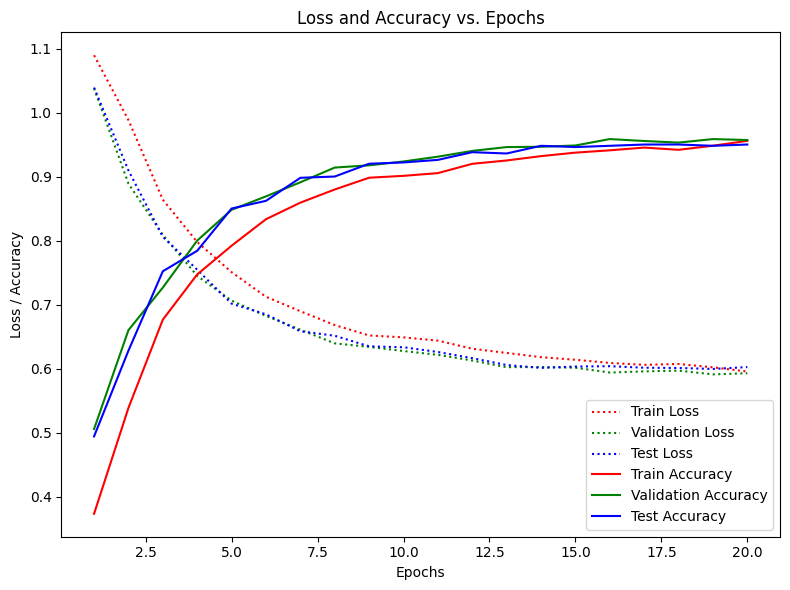

In [13]:
from torch import optim

lr = 0.06
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

  5%|▌         | 1/20 [00:08<02:35,  8.17s/it]

EPOCH: 01/20 LOSS: 1.0829 ACC: 0.3809  VAL-LOSS: 1.0193 VAL-ACC: 0.5055  TEST-LOSS: 1.0419 TEST-ACC: 0.4820 


 10%|█         | 2/20 [00:16<02:24,  8.02s/it]

EPOCH: 02/20 LOSS: 0.9674 ACC: 0.5620  VAL-LOSS: 0.8727 VAL-ACC: 0.6670  TEST-LOSS: 0.8787 TEST-ACC: 0.6720 


 15%|█▌        | 3/20 [00:24<02:15,  7.98s/it]

EPOCH: 03/20 LOSS: 0.8494 ACC: 0.6912  VAL-LOSS: 0.7744 VAL-ACC: 0.7790  TEST-LOSS: 0.7810 TEST-ACC: 0.7720 


 20%|██        | 4/20 [00:31<02:05,  7.82s/it]

EPOCH: 04/20 LOSS: 0.7656 ACC: 0.7815  VAL-LOSS: 0.7102 VAL-ACC: 0.8370  TEST-LOSS: 0.7097 TEST-ACC: 0.8420 


 25%|██▌       | 5/20 [00:39<01:58,  7.93s/it]

EPOCH: 05/20 LOSS: 0.7265 ACC: 0.8189  VAL-LOSS: 0.6816 VAL-ACC: 0.8680  TEST-LOSS: 0.6947 TEST-ACC: 0.8500 


 30%|███       | 6/20 [00:48<01:54,  8.18s/it]

EPOCH: 06/20 LOSS: 0.6909 ACC: 0.8551  VAL-LOSS: 0.6564 VAL-ACC: 0.8940  TEST-LOSS: 0.6737 TEST-ACC: 0.8760 


 35%|███▌      | 7/20 [00:57<01:48,  8.34s/it]

EPOCH: 07/20 LOSS: 0.6700 ACC: 0.8808  VAL-LOSS: 0.6355 VAL-ACC: 0.9140  TEST-LOSS: 0.6432 TEST-ACC: 0.9120 


 40%|████      | 8/20 [01:05<01:41,  8.46s/it]

EPOCH: 08/20 LOSS: 0.6599 ACC: 0.8888  VAL-LOSS: 0.6294 VAL-ACC: 0.9210  TEST-LOSS: 0.6397 TEST-ACC: 0.9140 


 45%|████▌     | 9/20 [01:14<01:34,  8.55s/it]

EPOCH: 09/20 LOSS: 0.6483 ACC: 0.8992  VAL-LOSS: 0.6251 VAL-ACC: 0.9270  TEST-LOSS: 0.6321 TEST-ACC: 0.9100 


 50%|█████     | 10/20 [01:23<01:26,  8.64s/it]

EPOCH: 10/20 LOSS: 0.6442 ACC: 0.9043  VAL-LOSS: 0.6095 VAL-ACC: 0.9415  TEST-LOSS: 0.6219 TEST-ACC: 0.9280 


 55%|█████▌    | 11/20 [01:32<01:19,  8.84s/it]

EPOCH: 11/20 LOSS: 0.6362 ACC: 0.9143  VAL-LOSS: 0.6036 VAL-ACC: 0.9485  TEST-LOSS: 0.6241 TEST-ACC: 0.9240 


 60%|██████    | 12/20 [01:41<01:11,  8.89s/it]

EPOCH: 12/20 LOSS: 0.6281 ACC: 0.9209  VAL-LOSS: 0.5977 VAL-ACC: 0.9545  TEST-LOSS: 0.6080 TEST-ACC: 0.9380 


 65%|██████▌   | 13/20 [01:50<01:02,  8.97s/it]

EPOCH: 13/20 LOSS: 0.6238 ACC: 0.9247  VAL-LOSS: 0.6206 VAL-ACC: 0.9290  TEST-LOSS: 0.6298 TEST-ACC: 0.9200 


 70%|███████   | 14/20 [01:59<00:53,  8.93s/it]

EPOCH: 14/20 LOSS: 0.6253 ACC: 0.9248  VAL-LOSS: 0.5955 VAL-ACC: 0.9555  TEST-LOSS: 0.6119 TEST-ACC: 0.9400 


 75%|███████▌  | 15/20 [02:08<00:44,  8.85s/it]

EPOCH: 15/20 LOSS: 0.6167 ACC: 0.9335  VAL-LOSS: 0.5994 VAL-ACC: 0.9540  TEST-LOSS: 0.6049 TEST-ACC: 0.9500 


 80%|████████  | 16/20 [02:16<00:34,  8.71s/it]

EPOCH: 16/20 LOSS: 0.6142 ACC: 0.9364  VAL-LOSS: 0.6027 VAL-ACC: 0.9455  TEST-LOSS: 0.6008 TEST-ACC: 0.9520 


 85%|████████▌ | 17/20 [02:25<00:26,  8.68s/it]

EPOCH: 17/20 LOSS: 0.6099 ACC: 0.9420  VAL-LOSS: 0.5837 VAL-ACC: 0.9685  TEST-LOSS: 0.5916 TEST-ACC: 0.9580 


 90%|█████████ | 18/20 [02:34<00:17,  8.68s/it]

EPOCH: 18/20 LOSS: 0.6095 ACC: 0.9401  VAL-LOSS: 0.5872 VAL-ACC: 0.9630  TEST-LOSS: 0.5916 TEST-ACC: 0.9580 


 95%|█████████▌| 19/20 [02:42<00:08,  8.71s/it]

EPOCH: 19/20 LOSS: 0.6131 ACC: 0.9375  VAL-LOSS: 0.5866 VAL-ACC: 0.9635  TEST-LOSS: 0.5921 TEST-ACC: 0.9620 


100%|██████████| 20/20 [02:51<00:00,  8.57s/it]

EPOCH: 20/20 LOSS: 0.6081 ACC: 0.9419  VAL-LOSS: 0.5787 VAL-ACC: 0.9725  TEST-LOSS: 0.5827 TEST-ACC: 0.9720 


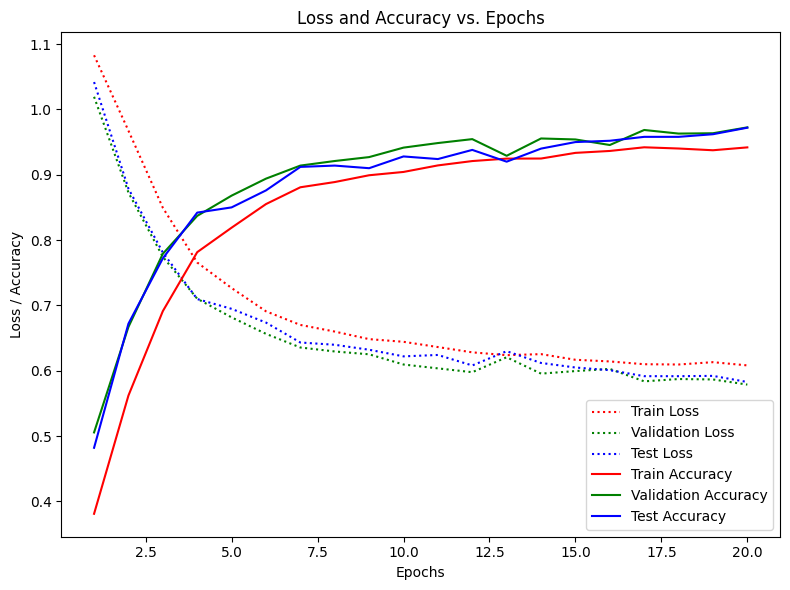

In [14]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False), # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16), # Adjust the batch normalization layer accordingly
    nn.Dropout(0.2),
    nn.Conv2d(16, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
    nn.Softmax(dim=1)
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

  5%|▌         | 1/20 [00:12<04:00, 12.64s/it]

EPOCH: 01/20 LOSS: 1.0856 ACC: 0.3884  VAL-LOSS: 1.0394 VAL-ACC: 0.4695  TEST-LOSS: 1.0325 TEST-ACC: 0.5060 


 10%|█         | 2/20 [00:24<03:44, 12.47s/it]

EPOCH: 02/20 LOSS: 0.9582 ACC: 0.5764  VAL-LOSS: 0.8826 VAL-ACC: 0.6595  TEST-LOSS: 0.8861 TEST-ACC: 0.6420 


 15%|█▌        | 3/20 [00:37<03:29, 12.33s/it]

EPOCH: 03/20 LOSS: 0.8373 ACC: 0.7023  VAL-LOSS: 0.7907 VAL-ACC: 0.7530  TEST-LOSS: 0.8131 TEST-ACC: 0.7280 


 20%|██        | 4/20 [00:49<03:18, 12.38s/it]

EPOCH: 04/20 LOSS: 0.7637 ACC: 0.7833  VAL-LOSS: 0.7287 VAL-ACC: 0.8135  TEST-LOSS: 0.7450 TEST-ACC: 0.8080 


 25%|██▌       | 5/20 [01:02<03:09, 12.65s/it]

EPOCH: 05/20 LOSS: 0.7218 ACC: 0.8245  VAL-LOSS: 0.6923 VAL-ACC: 0.8570  TEST-LOSS: 0.7222 TEST-ACC: 0.8200 


 30%|███       | 6/20 [01:15<02:59, 12.85s/it]

EPOCH: 06/20 LOSS: 0.6879 ACC: 0.8621  VAL-LOSS: 0.6770 VAL-ACC: 0.8705  TEST-LOSS: 0.6998 TEST-ACC: 0.8540 


 35%|███▌      | 7/20 [01:28<02:46, 12.80s/it]

EPOCH: 07/20 LOSS: 0.6629 ACC: 0.8841  VAL-LOSS: 0.6565 VAL-ACC: 0.8955  TEST-LOSS: 0.6676 TEST-ACC: 0.8760 


 40%|████      | 8/20 [01:41<02:33, 12.83s/it]

EPOCH: 08/20 LOSS: 0.6530 ACC: 0.8959  VAL-LOSS: 0.6512 VAL-ACC: 0.9020  TEST-LOSS: 0.6645 TEST-ACC: 0.8840 


 45%|████▌     | 9/20 [01:54<02:22, 12.91s/it]

EPOCH: 09/20 LOSS: 0.6446 ACC: 0.9045  VAL-LOSS: 0.6432 VAL-ACC: 0.9065  TEST-LOSS: 0.6674 TEST-ACC: 0.8820 


 50%|█████     | 10/20 [02:08<02:13, 13.34s/it]

EPOCH: 10/20 LOSS: 0.6285 ACC: 0.9216  VAL-LOSS: 0.6270 VAL-ACC: 0.9225  TEST-LOSS: 0.6244 TEST-ACC: 0.9260 


 55%|█████▌    | 11/20 [02:22<01:59, 13.26s/it]

EPOCH: 11/20 LOSS: 0.6252 ACC: 0.9252  VAL-LOSS: 0.6207 VAL-ACC: 0.9310  TEST-LOSS: 0.6272 TEST-ACC: 0.9200 


 60%|██████    | 12/20 [02:34<01:45, 13.17s/it]

EPOCH: 12/20 LOSS: 0.6159 ACC: 0.9345  VAL-LOSS: 0.6157 VAL-ACC: 0.9360  TEST-LOSS: 0.6232 TEST-ACC: 0.9240 


 65%|██████▌   | 13/20 [02:48<01:32, 13.21s/it]

EPOCH: 13/20 LOSS: 0.6155 ACC: 0.9348  VAL-LOSS: 0.6176 VAL-ACC: 0.9320  TEST-LOSS: 0.6268 TEST-ACC: 0.9200 


 70%|███████   | 14/20 [03:04<01:23, 13.97s/it]

EPOCH: 14/20 LOSS: 0.6069 ACC: 0.9423  VAL-LOSS: 0.6109 VAL-ACC: 0.9420  TEST-LOSS: 0.6124 TEST-ACC: 0.9300 


 75%|███████▌  | 15/20 [03:17<01:09, 13.96s/it]

EPOCH: 15/20 LOSS: 0.6038 ACC: 0.9459  VAL-LOSS: 0.6053 VAL-ACC: 0.9475  TEST-LOSS: 0.6066 TEST-ACC: 0.9440 


 80%|████████  | 16/20 [03:32<00:56, 14.06s/it]

EPOCH: 16/20 LOSS: 0.5976 ACC: 0.9544  VAL-LOSS: 0.6005 VAL-ACC: 0.9470  TEST-LOSS: 0.6010 TEST-ACC: 0.9460 


 85%|████████▌ | 17/20 [03:46<00:42, 14.11s/it]

EPOCH: 17/20 LOSS: 0.6021 ACC: 0.9472  VAL-LOSS: 0.6021 VAL-ACC: 0.9490  TEST-LOSS: 0.5970 TEST-ACC: 0.9540 


 90%|█████████ | 18/20 [04:00<00:28, 14.21s/it]

EPOCH: 18/20 LOSS: 0.6020 ACC: 0.9468  VAL-LOSS: 0.5969 VAL-ACC: 0.9540  TEST-LOSS: 0.5929 TEST-ACC: 0.9580 


 95%|█████████▌| 19/20 [04:14<00:14, 14.17s/it]

EPOCH: 19/20 LOSS: 0.5936 ACC: 0.9573  VAL-LOSS: 0.5954 VAL-ACC: 0.9530  TEST-LOSS: 0.5980 TEST-ACC: 0.9540 


100%|██████████| 20/20 [04:29<00:00, 13.45s/it]

EPOCH: 20/20 LOSS: 0.5905 ACC: 0.9603  VAL-LOSS: 0.6008 VAL-ACC: 0.9500  TEST-LOSS: 0.5934 TEST-ACC: 0.9560 


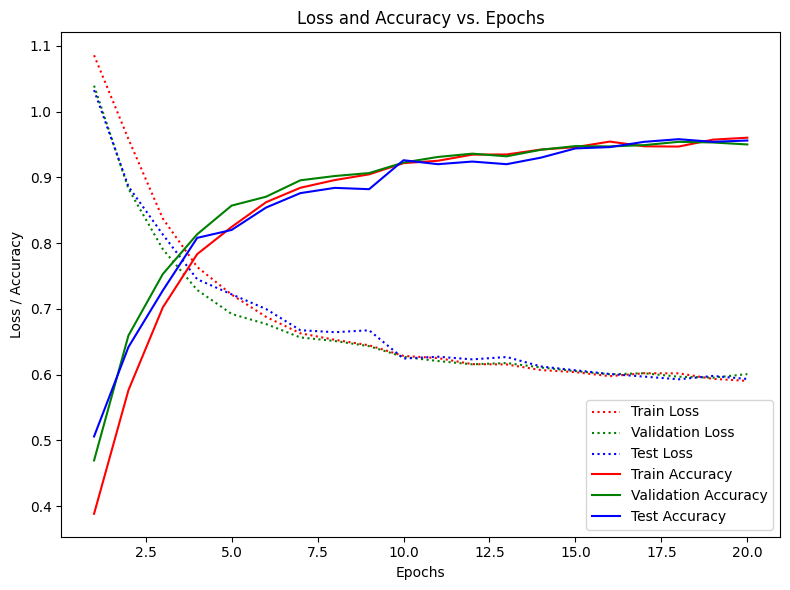

In [15]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
    nn.Linear(100, 3),
    nn.Softmax(dim=1)
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

  5%|▌         | 1/20 [00:17<05:24, 17.10s/it]

EPOCH: 01/20 LOSS: 1.0986 ACC: 0.3473  VAL-LOSS: 1.0966 VAL-ACC: 0.3605  TEST-LOSS: 1.0959 TEST-ACC: 0.3680 


 10%|█         | 2/20 [00:32<04:50, 16.15s/it]

EPOCH: 02/20 LOSS: 1.0910 ACC: 0.3817  VAL-LOSS: 1.0868 VAL-ACC: 0.4165  TEST-LOSS: 1.0869 TEST-ACC: 0.4180 


 15%|█▌        | 3/20 [00:49<04:41, 16.54s/it]

EPOCH: 03/20 LOSS: 1.0692 ACC: 0.4492  VAL-LOSS: 1.0561 VAL-ACC: 0.4755  TEST-LOSS: 1.0579 TEST-ACC: 0.4920 


 20%|██        | 4/20 [01:06<04:24, 16.51s/it]

EPOCH: 04/20 LOSS: 1.0132 ACC: 0.5301  VAL-LOSS: 0.9743 VAL-ACC: 0.5830  TEST-LOSS: 0.9591 TEST-ACC: 0.5920 


 25%|██▌       | 5/20 [01:21<04:03, 16.26s/it]

EPOCH: 05/20 LOSS: 0.9316 ACC: 0.6248  VAL-LOSS: 0.8913 VAL-ACC: 0.6690  TEST-LOSS: 0.8992 TEST-ACC: 0.6640 


 30%|███       | 6/20 [01:37<03:43, 15.99s/it]

EPOCH: 06/20 LOSS: 0.8759 ACC: 0.6744  VAL-LOSS: 0.8495 VAL-ACC: 0.7120  TEST-LOSS: 0.8447 TEST-ACC: 0.7220 


 35%|███▌      | 7/20 [01:52<03:23, 15.64s/it]

EPOCH: 07/20 LOSS: 0.8331 ACC: 0.7180  VAL-LOSS: 0.8246 VAL-ACC: 0.7190  TEST-LOSS: 0.8250 TEST-ACC: 0.7180 


 40%|████      | 8/20 [02:07<03:05, 15.48s/it]

EPOCH: 08/20 LOSS: 0.8022 ACC: 0.7476  VAL-LOSS: 0.7938 VAL-ACC: 0.7530  TEST-LOSS: 0.8002 TEST-ACC: 0.7420 


 45%|████▌     | 9/20 [02:22<02:49, 15.43s/it]

EPOCH: 09/20 LOSS: 0.7835 ACC: 0.7699  VAL-LOSS: 0.7843 VAL-ACC: 0.7665  TEST-LOSS: 0.7810 TEST-ACC: 0.7620 


 50%|█████     | 10/20 [02:37<02:33, 15.35s/it]

EPOCH: 10/20 LOSS: 0.7707 ACC: 0.7780  VAL-LOSS: 0.7654 VAL-ACC: 0.7770  TEST-LOSS: 0.7661 TEST-ACC: 0.7660 


 55%|█████▌    | 11/20 [02:52<02:16, 15.20s/it]

EPOCH: 11/20 LOSS: 0.7532 ACC: 0.7983  VAL-LOSS: 0.7553 VAL-ACC: 0.7950  TEST-LOSS: 0.7672 TEST-ACC: 0.7660 


 60%|██████    | 12/20 [03:07<02:01, 15.18s/it]

EPOCH: 12/20 LOSS: 0.7405 ACC: 0.8091  VAL-LOSS: 0.7488 VAL-ACC: 0.8025  TEST-LOSS: 0.7511 TEST-ACC: 0.7900 


 65%|██████▌   | 13/20 [03:23<01:47, 15.32s/it]

EPOCH: 13/20 LOSS: 0.7234 ACC: 0.8269  VAL-LOSS: 0.7440 VAL-ACC: 0.7970  TEST-LOSS: 0.7423 TEST-ACC: 0.7980 


 70%|███████   | 14/20 [03:39<01:32, 15.40s/it]

EPOCH: 14/20 LOSS: 0.7154 ACC: 0.8349  VAL-LOSS: 0.7360 VAL-ACC: 0.8110  TEST-LOSS: 0.7406 TEST-ACC: 0.7920 


 75%|███████▌  | 15/20 [03:54<01:16, 15.39s/it]

EPOCH: 15/20 LOSS: 0.7095 ACC: 0.8403  VAL-LOSS: 0.7273 VAL-ACC: 0.8215  TEST-LOSS: 0.7282 TEST-ACC: 0.8120 


 80%|████████  | 16/20 [04:10<01:02, 15.73s/it]

EPOCH: 16/20 LOSS: 0.7080 ACC: 0.8401  VAL-LOSS: 0.7256 VAL-ACC: 0.8195  TEST-LOSS: 0.7125 TEST-ACC: 0.8300 


 85%|████████▌ | 17/20 [04:27<00:47, 15.98s/it]

EPOCH: 17/20 LOSS: 0.6968 ACC: 0.8551  VAL-LOSS: 0.7185 VAL-ACC: 0.8300  TEST-LOSS: 0.7042 TEST-ACC: 0.8440 


 90%|█████████ | 18/20 [04:43<00:32, 16.06s/it]

EPOCH: 18/20 LOSS: 0.6907 ACC: 0.8589  VAL-LOSS: 0.7145 VAL-ACC: 0.8325  TEST-LOSS: 0.7060 TEST-ACC: 0.8380 


 95%|█████████▌| 19/20 [05:00<00:16, 16.27s/it]

EPOCH: 19/20 LOSS: 0.6833 ACC: 0.8695  VAL-LOSS: 0.7081 VAL-ACC: 0.8420  TEST-LOSS: 0.6969 TEST-ACC: 0.8440 


100%|██████████| 20/20 [05:16<00:00, 15.84s/it]

EPOCH: 20/20 LOSS: 0.6870 ACC: 0.8628  VAL-LOSS: 0.7023 VAL-ACC: 0.8465  TEST-LOSS: 0.6913 TEST-ACC: 0.8500 


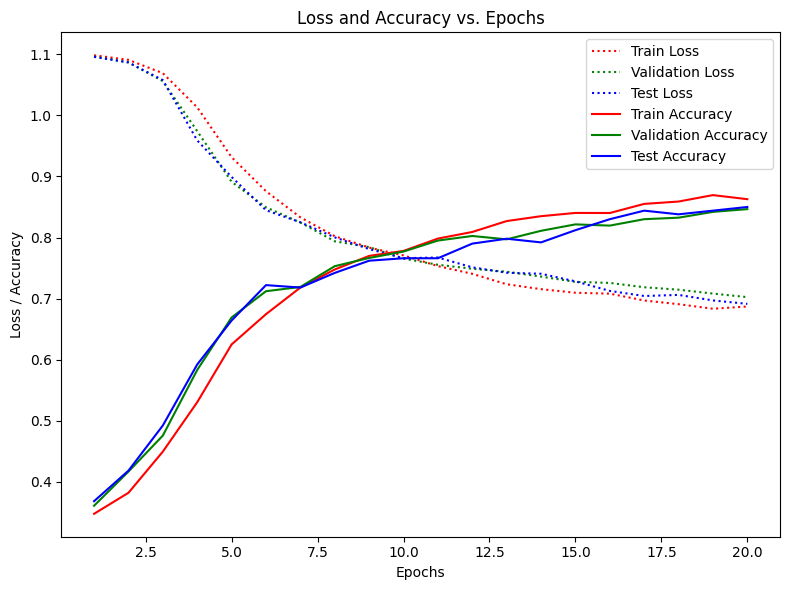

In [16]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
    nn.Softmax(dim=1)
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [17]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [18]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [19]:
class EmbeddingNet_Sym(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet_Sym, self).__init__()

        self.front_layer = nn.Sequential(
                sc.Slice(rotation=4, reflection=False),
                sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
                nn.ReLU(inplace=True),
                sc.SymmetryPool(),
                nn.BatchNorm2d(32),
                nn.Dropout(0.2),
                nn.Conv2d(32, 64, kernel_size=3, stride=3),
                nn.ReLU(inplace=True),
                sc.Slice(rotation=4, reflection=False),
                sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
                nn.ReLU(inplace=True),
                sc.SymmetryPool(),
                nn.BatchNorm2d(10),
                nn.Dropout(0.2),
                Lambda(lambda x: x.view(x.size(0), -1)),
                nn.Linear(40, 100),
                nn.ReLU(inplace=True),
            )

        self.last_layer = nn.Linear(100, 200)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

In [20]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        # Convert the image and label to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label
    
dataset = CustomDataset(X, y)

In [21]:
N = 200  # Number of classes in each mini-batch
m = 5   # Number of samples from each class

train_batch_sampler = BalancedBatchSampler(y, n_classes=N, n_samples=m)

triplets_train_loader = torch.utils.data.DataLoader(dataset, batch_sampler=train_batch_sampler)


In [22]:
from itertools import combinations

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None
    

    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)

In [23]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [24]:
from sklearn.metrics import pairwise_distances
import torch
import torch.nn as nn
import torch.optim as optim

def query_performance(model, queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0

    queries_np = queries
    targets_np = targets


    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries_np[i][None]).float().to(device)
        t = torch.from_numpy(targets_np[i]).float().to(device)

        with torch.no_grad():
            emb_q = model.get_embedding(q).cpu().numpy()  
            emb_t = model.get_embedding(t).cpu().numpy()  
        
            dists = pairwise_distances(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1

    return 100 * cnt / gt.shape[0]

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):

        top_1_accuracies = []
        top_2_accuracies = []
        top_3_accuracies = []
        train_losses_mean = []
        for epoch in tqdm(range(self.epochs)):
                 
            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
                
            self.model.eval()
            top_1_accuracy = query_performance(self.model, queries, targets, gt, top=1)
            top_2_accuracy = query_performance(self.model, queries, targets, gt, top=2)
            top_3_accuracy = query_performance(self.model, queries, targets, gt, top=3)
            
            top_1_accuracies.append(top_1_accuracy)
            top_2_accuracies.append(top_2_accuracy)
            top_3_accuracies.append(top_3_accuracy)
            
            train_losses_mean.append(np.mean(train_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'top-1 accuracy: {top_1_accuracy:.2f}%')
        
        # Plot losses and accuracies
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs+1), train_losses_mean, 'r:', label='Train Loss')
        plt.plot(range(1, self.epochs+1), [val/100 for val in top_1_accuracies], 'b', label='Top 1 Accuracy')
        plt.plot(range(1, self.epochs+1), [val/100 for val in top_2_accuracies], 'b', label='Top 2 Accuracy')
        plt.plot(range(1, self.epochs+1), [val/100 for val in top_3_accuracies], 'b', label='Top 3 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss / Accuracy')
        plt.title('Loss and Accuracy vs. Epochs')
        plt.legend()
        plt.tight_layout()
        plt.show()

 20%|██        | 1/5 [01:34<06:18, 94.58s/it]

EPOCH: 1/5 LOSS: 4.5926 top-1 accuracy: 32.00%


 40%|████      | 2/5 [03:09<04:44, 94.87s/it]

EPOCH: 2/5 LOSS: 4.4210 top-1 accuracy: 33.33%


 60%|██████    | 3/5 [04:44<03:09, 94.87s/it]

EPOCH: 3/5 LOSS: 4.1589 top-1 accuracy: 35.67%


 80%|████████  | 4/5 [06:16<01:33, 93.78s/it]

EPOCH: 4/5 LOSS: 4.0029 top-1 accuracy: 39.33%


100%|██████████| 5/5 [07:51<00:00, 94.39s/it]

EPOCH: 5/5 LOSS: 3.8071 top-1 accuracy: 43.00%


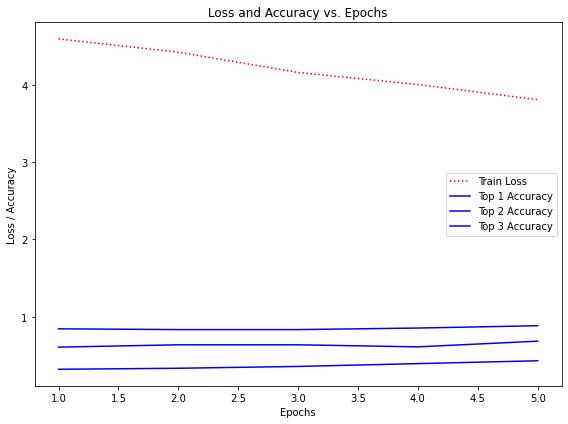

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
embedding_net_sym = EmbeddingNet_Sym()
model_sym = embedding_net_sym.to(device)

# margin value
margin=1

# criterion
criterion_sym = TripletLoss(margin, Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(model_sym.parameters(), lr=0.0001, momentum=0.9)

# trainer
trainer = Trainer(model=model_sym,
                  device=device,
                  criterion=criterion_sym,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  epochs=10)

# start training
trainer.run_trainer()